<a href="https://colab.research.google.com/github/Uniholder/DeepLearningSchool/blob/main/2_semester/6_Transformers/%5Bhomework_part1%5DGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Sat Nov 13 23:21:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# !pip install -q transformers datasets tokenizers

     |████████████████████████████████| 3.1 MB 9.5 MB/s 
     |████████████████████████████████| 290 kB 54.2 MB/s 
     |████████████████████████████████| 3.3 MB 51.2 MB/s 
     |████████████████████████████████| 596 kB 61.3 MB/s 
     |████████████████████████████████| 895 kB 43.6 MB/s 
     |████████████████████████████████| 59 kB 7.8 MB/s 
     |████████████████████████████████| 132 kB 73.3 MB/s 
     |████████████████████████████████| 1.1 MB 55.4 MB/s 
     |████████████████████████████████| 243 kB 67.1 MB/s 
     |████████████████████████████████| 271 kB 68.4 MB/s 
     |████████████████████████████████| 192 kB 78.5 MB/s 
     |████████████████████████████████| 160 kB 71.0 MB/s 


# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [4]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [5]:
emotion_dataset = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [ ]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
emotion_dataset["train"]["label"][0]

0

In [ ]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [6]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [ ]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [ ]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [ ]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [ ]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [7]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Returns dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(
            text=text,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        target = self.label2num[label]
        return {
            "input_ids":  tokenizer_output['input_ids'].squeeze(),
            "mask": tokenizer_output['attention_mask'].squeeze(),
            "target": target
        }
        
    def __len__(self):
        """
        Returns length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [8]:
train_dataset = TweetDataset('train', emotion_dataset, tokenizer, 128)
valid_dataset = TweetDataset('validation', emotion_dataset, tokenizer, 128)
test_dataset = TweetDataset('test', emotion_dataset, tokenizer, 128)

In [9]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [10]:
config = GPT2Config.from_pretrained(
    "distilgpt2",  # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device)  # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [13]:
lr = 1e-4

optimizer = torch.optim.Adam(model_0.parameters(), lr)
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.StepLR()

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [ ]:
tokenized = tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128,  # максимальная длина текста
    padding="max_length",  # надо ли добавлять паддинг в конце?
    return_tensors="pt",  # возвращает pytorch тензоры
)
tokens = tokenized['input_ids'].to(device)
mask = tokenized['attention_mask'].to(device)

output = model_0(tokens, attention_mask=mask)

In [ ]:
output.logits

tensor([[ 0.6717, -0.4686,  0.1700,  0.1531, -0.0961, -0.6903, -1.4931,  0.8655]],
       device='cuda:0', grad_fn=<IndexBackward0>)

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [14]:
from tqdm.notebook import tqdm


num_epochs = 5

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        target = batch['target'].to(device)

        optimizer.zero_grad()

        outputs = model_0(input_ids, attention_mask=mask)
        logits = outputs.logits
        loss = criterion(logits, target)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            input_ids = batch['input_ids'].to(device)
            mask = batch['mask'].to(device)
            target = batch['target'].to(device)

            outputs = model_0(input_ids, attention_mask=mask)
            logits = outputs.logits

            loss = criterion(logits, target)
            valid_loss += loss
            valid_acc += torch.sum(torch.argmax(logits, dim=1) == target) / len(batch['input_ids'])

    print(f"Train Loss: {train_loss / len(train_loader)}",
          f"Valid Loss: {valid_loss / len(valid_loader)}",
          f"Valid Acc: {valid_acc / len(valid_loader)}")
    
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        mask = batch['mask'].to(device)
        target = batch['target'].to(device)

        outputs = model_0(input_ids, attention_mask=mask)
        logits = outputs.logits

        test_acc += torch.sum(torch.argmax(logits, dim=1) == target) / len(batch['input_ids'])

print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.792413442850113 Valid Loss: 0.5213285684585571 Valid Acc: 0.8331054449081421


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2797372931838036 Valid Loss: 0.35768505930900574 Valid Acc: 0.88427734375


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.13580504861474038 Valid Loss: 0.3264482617378235 Valid Acc: 0.892382800579071


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.09593755821883679 Valid Loss: 0.35540252923965454 Valid Acc: 0.8902343511581421


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.06845451658964156 Valid Loss: 0.3765983581542969 Valid Acc: 0.891796886920929


  0%|          | 0/16 [00:00<?, ?it/s]

Test Acc: 0.8934570550918579


In [15]:
# torch.save(model_0, 'model_0.pt')

После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [18]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn), seq

In [17]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [22]:
text = emotion_dataset['train']['text'][1]
tokens = tokenizer.tokenize(text)
text

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

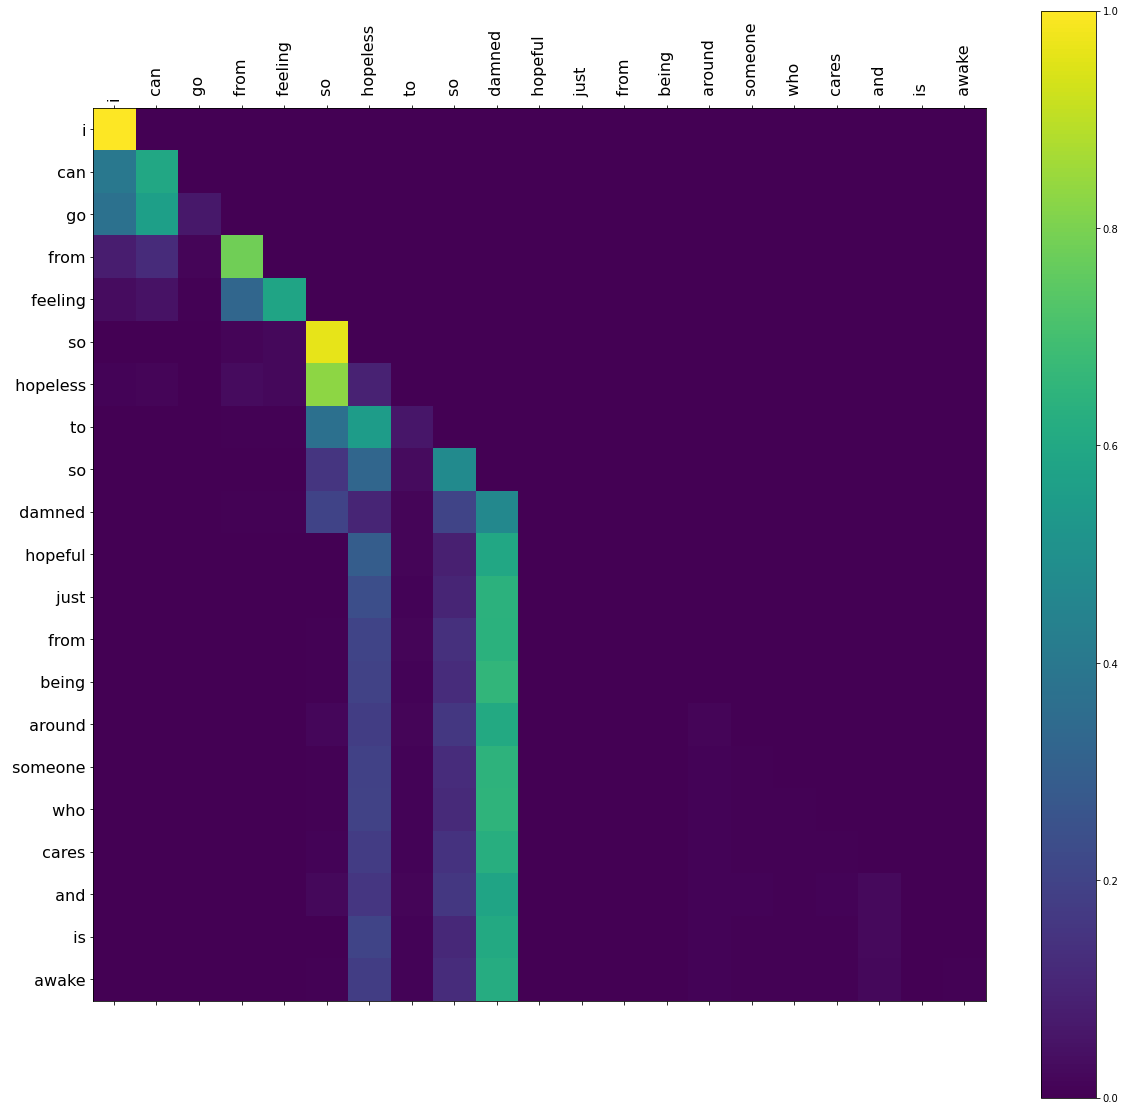

In [23]:
attns, seq = get_attention_matrixes(model_0, tokenizer, text)
show_attention(seq, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [ ]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

In [ ]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = ...
criterion = ...
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [ ]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        ...
        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            ...
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        ...
print(f"Test Acc: {test_acc / len(test_loader)}")

Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [ ]:
text = ... # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

In [ ]:
attns = get_ettention_matrixes(model, tokenizer, text)
show_attention(seq, attn[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >